This project aims to analyze monthly stock price data of Yes Bank, a prominent player in the Indian financial sector. The dataset comprises of closing, opening, highest, and lowest stock prices for each month. The primary objective is to develop a predictive model capable of forecasting the closing price of Yes Bank's stock for each month. Through comprehensive analysis and machine learning techniques, the project seeks to provide valuable insights into the stock's performance and offer predictive capabilities to stakeholders, aiding in informed decision-making within the financial domain.

**Goal**: Develop a predictive model to forecast the monthly closing price of Yes Bank's stock accurately.

In [1]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy.stats import shapiro, levene

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import mplfinance as mpf
import calendar

In [2]:
# importing dataset

df = pd.read_csv('data_YesBank_StockPrices.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close
0,Jul-05,13.00,14.00,11.25,12.46
1,Aug-05,12.58,14.88,12.55,13.42
2,Sep-05,13.48,14.87,12.27,13.30
3,Oct-05,13.20,14.47,12.40,12.99
4,Nov-05,13.35,13.88,12.88,13.41


In [4]:
# Dataset Rows & Columns count

print(f'No. of rows: {df.shape[0]}\nNo. of columns: {df.shape[1]}')

No. of rows: 185
No. of columns: 5


In [5]:
# Dataset Info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    185 non-null    object 
 1   Open    185 non-null    float64
 2   High    185 non-null    float64
 3   Low     185 non-null    float64
 4   Close   185 non-null    float64
dtypes: float64(4), object(1)
memory usage: 7.4+ KB


In [6]:
# Dataset Duplicate Value Count

print(f'No. of duplicate rows: {df.duplicated().sum()}')

No. of duplicate rows: 0


In [7]:
# Missing Values/Null Values Count

print(f'Null value count:\n\n{df.isnull().sum()}')

Null value count:

Date     0
Open     0
High     0
Low      0
Close    0
dtype: int64


In [8]:
# Dataset Columns

df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close'], dtype='object')

In [9]:
# Dataset Describe
df.describe().round(2)

,Open,High,Low,Close
count,185.00,185.00,185.00,185.00
mean,105.54,116.10,94.95,105.20
std,98.88,106.33,91.22,98.58
min,10.00,11.24,5.55,9.98
25%,33.80,36.14,28.51,33.45
50%,62.98,72.55,58.00,62.54
75%,153.00,169.19,138.35,153.30
max,369.95,404.00,345.50,367.90


#### Variable Description
- **Date**: Month and year
- **Open**: Opening price of the stock for each month
- **High**: Highest price of the stock recorded for each month
- **Low**: Lowest price of the stock recorded for each month
- **Close**: Closing price of the stock for each month

### Data Wrangling
- Firstly, I have converted the 'Date' column from a string (object) type to a datetime time. This will allow python to understand that the column contains dates.

- I have broken down the date into separate columns of 'month' and 'year'. This will not only allow us to see the average changes on a monthly or yearly basis, but it also allows the ML models to have some extra features which could possibly help build a better model.

- I've created separated columns for the quarterly, half-yearly and yearly simple moving averages for the closing price. This allows us to smooth out the curve and helps us in studing the trend.

- In order to plot Bollinger Bands, I've created columns for the uppper and lower bands around the 12 month moving average values (middle band). The width of the bands are twice the standard deviation of the moving averages.

In [10]:
# converting the date column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%b-%y')

# making new columns for month and year
df['month'] = df['Date'].dt.month_name()
df['year'] = df['Date'].dt.year

# calculating simple moving averages
df['SMA_3'] = df['Close'].rolling(window=3).mean()
df['SMA_6'] = df['Close'].rolling(window=6).mean()
df['SMA_12'] = df['Close'].rolling(window=12).mean()

# upper and lower bad for bollinger bands
df['UpperBand'] = df['SMA_12'] + 2*df['Close'].rolling(window=12).std()
df['LowerBand'] = df['SMA_12'] - 2*df['Close'].rolling(window=12).std()

### Data Visualization

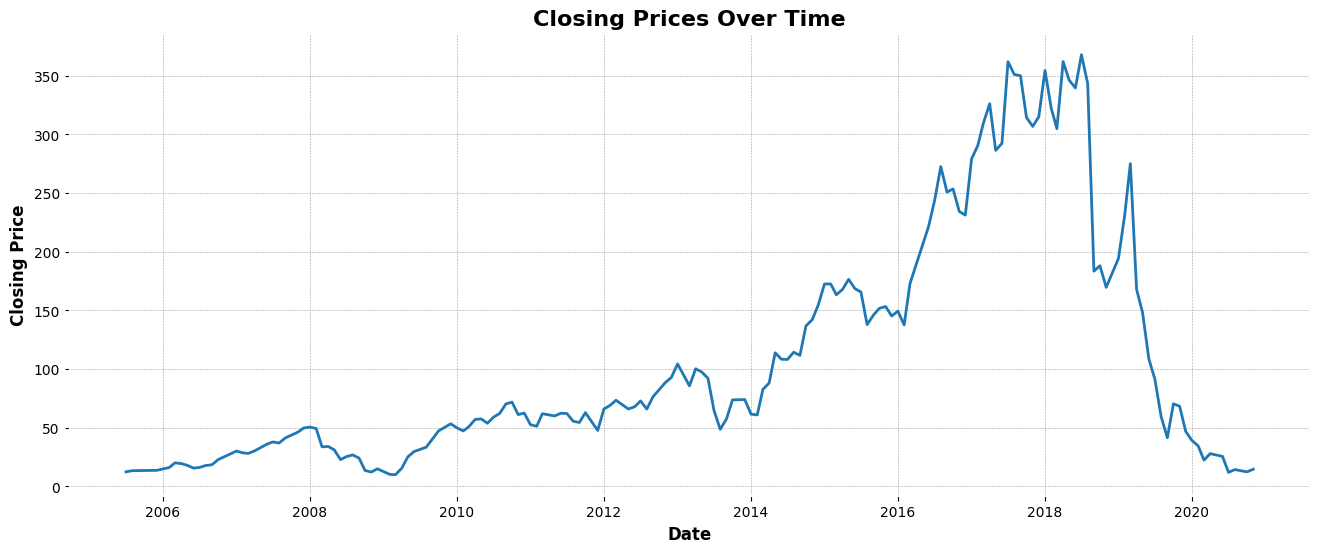

In [21]:
# line plot of closing price

plt.figure(figsize=(16, 6))
sns.lineplot(x='Date', y='Close', data=df)
plt.title('Closing Prices Over Time', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.xlabel('Date', fontdict={'fontsize': 12, 'fontweight': 'bold'})
plt.ylabel('Closing Price', fontdict={'fontsize': 12, 'fontweight': 'bold'})
plt.show()

By plotting the closing prices, we can easily observe how the stock price has evolved over the period of the dataset. There was a considerable spike in the closing prices of stocks between 2016 and 2019. The prices sharply drop after that. The sudden spike and then fall of the closing prices is certainly a reason to look at the business more closely, whether it be for positive or negative reasons.

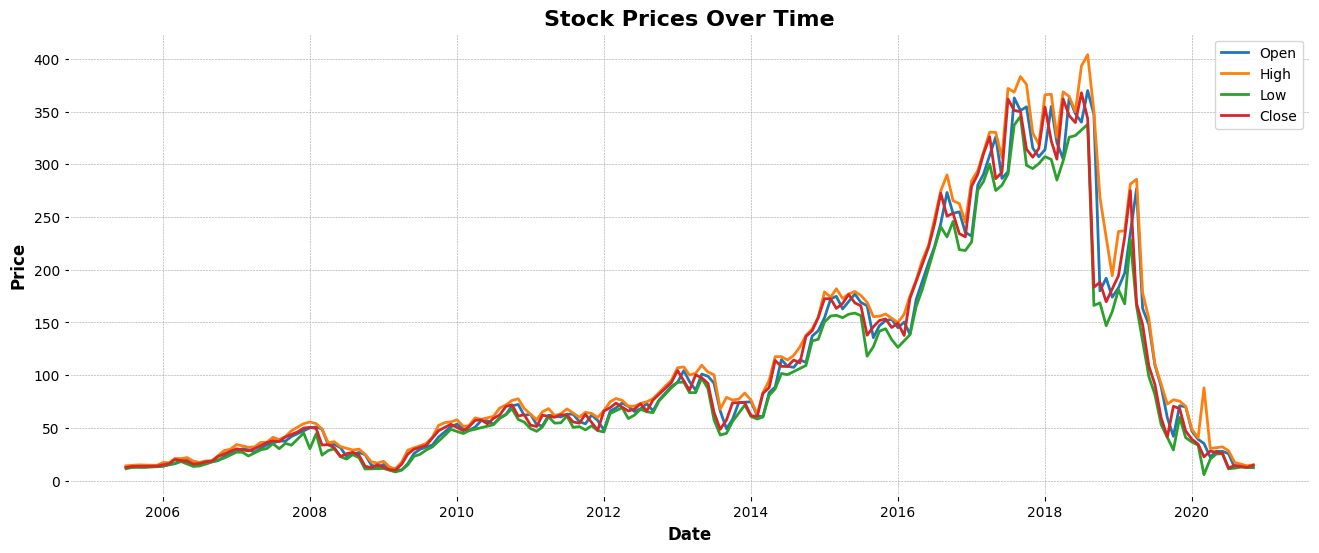

In [20]:
# comparison of price features using line plots

plt.figure(figsize=(16, 6))
sns.lineplot(x='Date', y='Open', data=df, label='Open')
sns.lineplot(x='Date', y='High', data=df, label='High')
sns.lineplot(x='Date', y='Low', data=df, label='Low')
sns.lineplot(x='Date', y='Close', data=df, label='Close')
plt.title('Stock Prices Over Time', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.xlabel('Date', fontdict={'fontsize': 12, 'fontweight': 'bold'})
plt.ylabel('Price', fontdict={'fontsize': 12, 'fontweight': 'bold'})
plt.legend()
plt.show()

Comparing these prices can show daily volatility and market behavior, helping traders to understand market sentiment and price movements within a trading day. While it's quite steady initially as one would expect, the volatility increases along the years. This coincides with the increase in stock prices. The most difference between the low and high points are shown during the peak of the stock prices. While volatility comes with its risk, it also attracts investors looking for short term profits thereby increasing the liquidity of the stock.

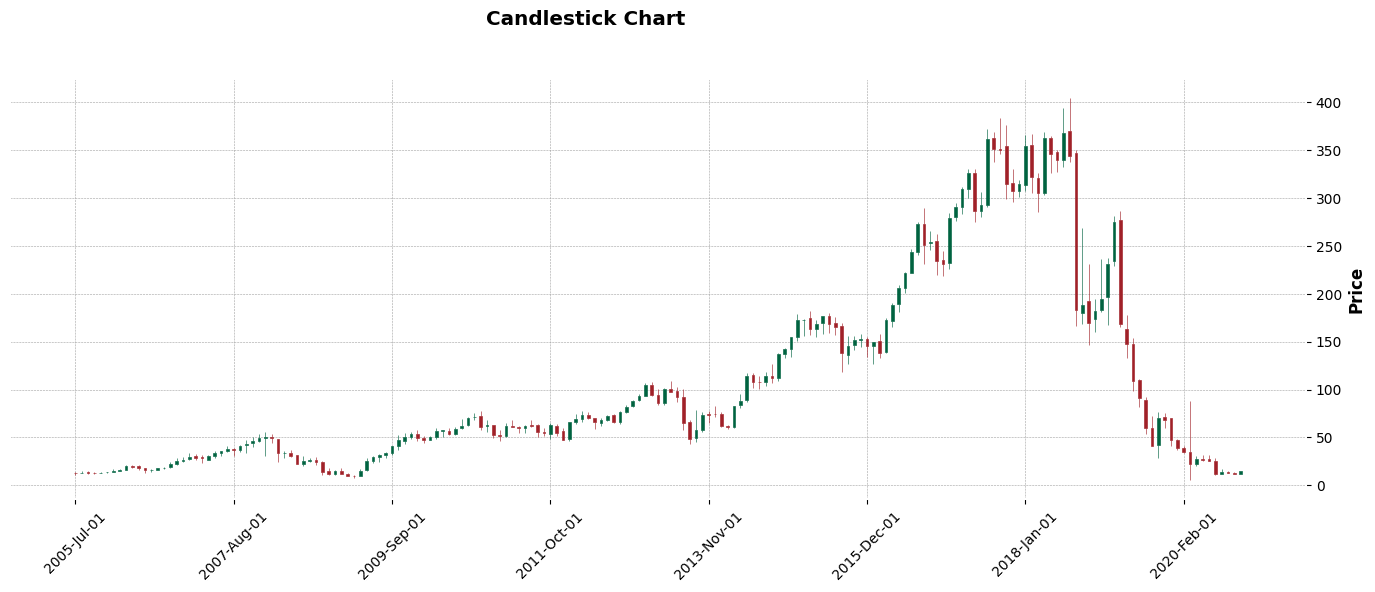

In [14]:
# creating a temporary dataframe and making the date column as its index for the candlestick chart
_ = df[['Date','Open', 'Low', 'High', 'Close']]
_.set_index('Date', inplace=True)

# plotting a candlestick chart
mpf.plot(_, type='candle', style='charles', title='Candlestick Chart', ylabel='Price', figsize=(18, 6))

Candlestick charts provide a more detailed view of price action, showing the opening, high, low, and closing price for each time period in a compact and informative manner. As also seen from the previous plot, the price is most volatile around the year 2018.

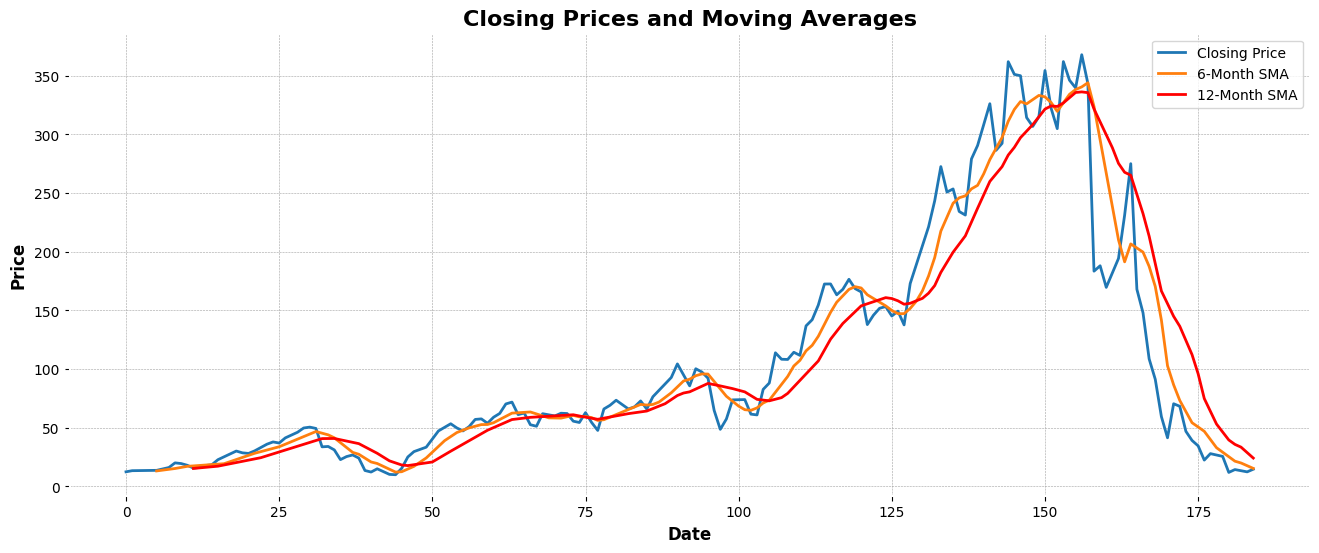

In [19]:
# comparing the closing price with its moving averages

plt.figure(figsize=(16, 6))
sns.lineplot(x=df.index, y='Close', data=df, label='Closing Price')
sns.lineplot(x=df.index, y='SMA_6', data=df, label='6-Month SMA')
sns.lineplot(x=df.index, y='SMA_12', data=df, label='12-Month SMA', color='red')
plt.title('Closing Prices and Moving Averages', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Moving averages help in filtering out noise and identifying the trend direction. The closing price peaked between 2018 and 2019. The gained insight will compel one to study the market during that period in order to understand why the price peak at the time that it did.

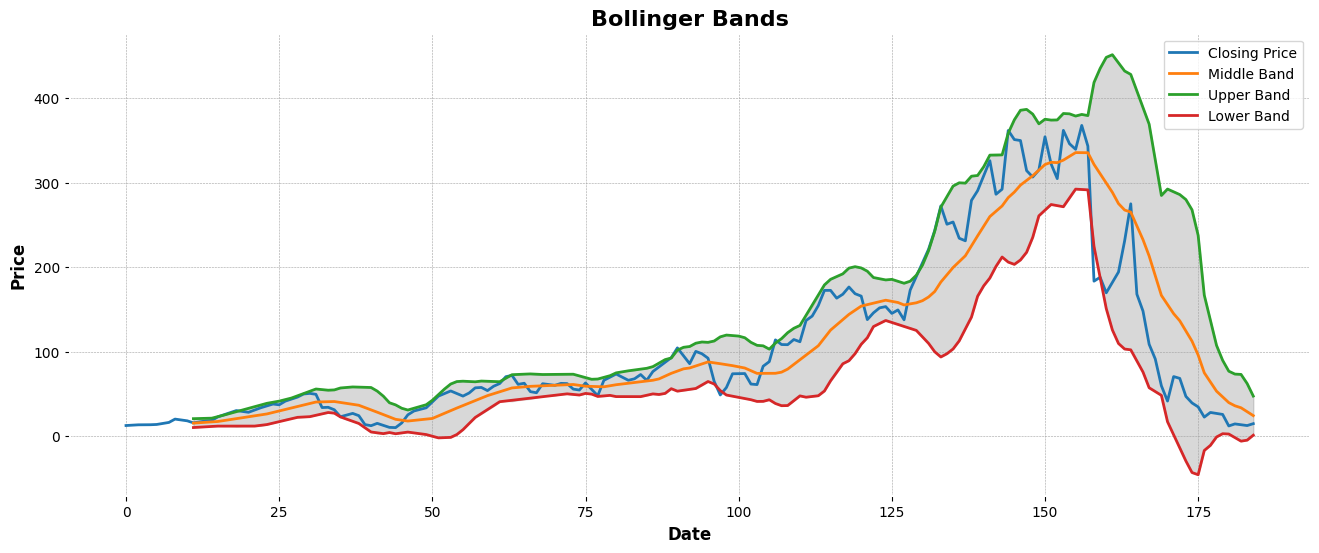

In [18]:
# plotting bollinger bands for the closing price

plt.figure(figsize=(16, 6))
sns.lineplot(x=df.index, y='Close', data=df, label='Closing Price')
sns.lineplot(x=df.index, y='SMA_12', data=df, label='Middle Band')
sns.lineplot(x=df.index, y='UpperBand', data=df, label='Upper Band')
sns.lineplot(x=df.index, y='LowerBand', data=df, label='Lower Band')
plt.fill_between(df.index, df['LowerBand'], df['UpperBand'], color='gray', alpha=0.3)
plt.title('Bollinger Bands', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Bollinger Bands are a type of volatility indicator that show how much the price has deviated from its average. The increasing width of the band is a clear indication of the increasing volatality of the closing price of the stocks over the years. 

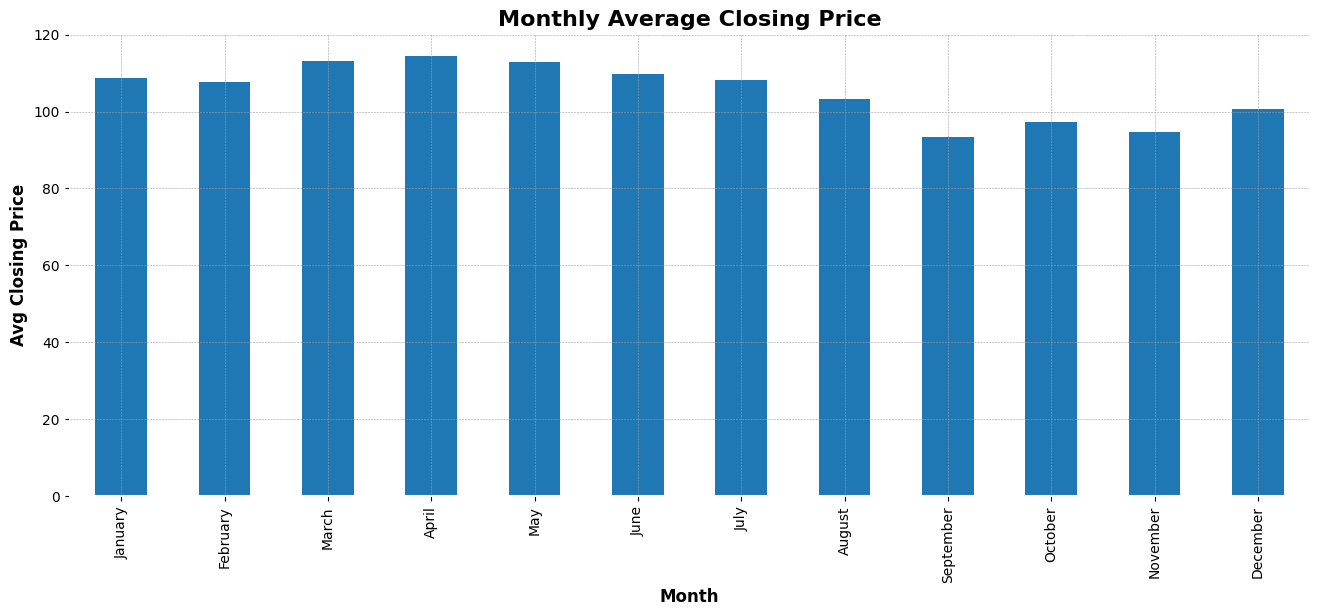

In [17]:
# using group by to get the mean closing prices for each month
_ = df.groupby(df['Date'].dt.month,sort=True)['Close'].mean()
# converting series indices from integers to month names
_.index = _.index.map(lambda x: calendar.month_name[x])

_.plot(kind='bar', figsize=(16,6))
plt.title('Monthly Average Closing Price', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.ylabel('Avg Closing Price')
plt.xlabel('Month')
plt.show()

To visualize the average closing prices per month for all years. The bar chart is suitable to make such comparisons. The average closing prices are highest around April. This could be a seasonal trend or due to the fact that many companies submit their first quarterly earnings report. While such a trend is not uncommon to see, but still a deeper inspection can be done to determine the reasons why this could be happening.

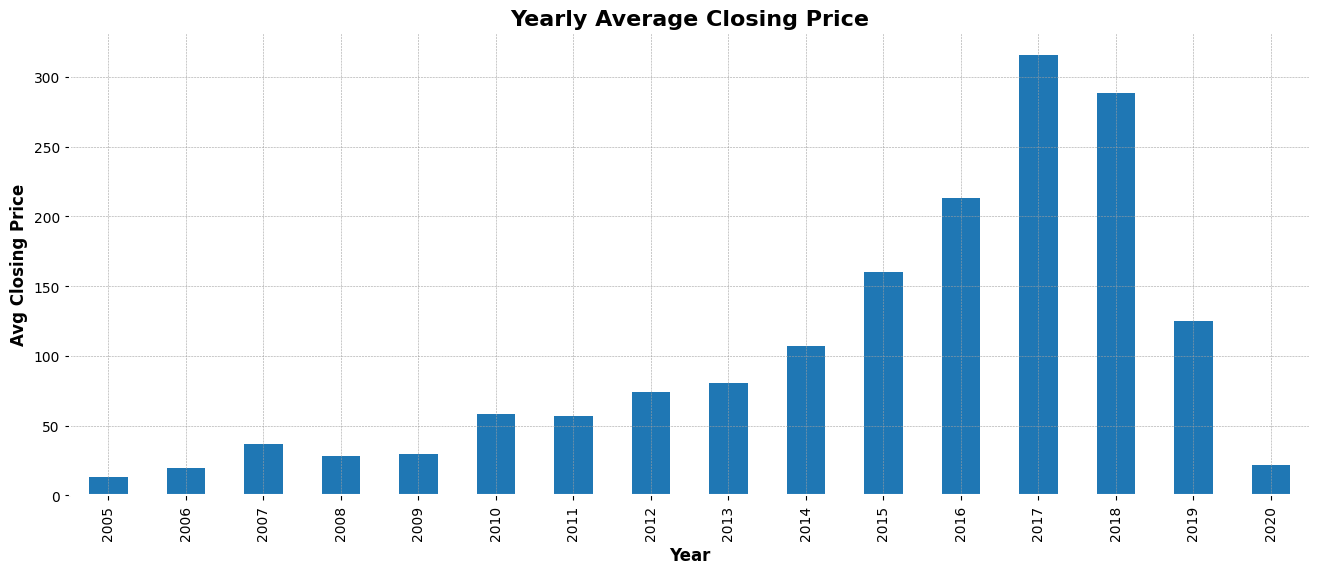

In [22]:
_ = df.groupby('year',sort=True)['Close'].mean()

_.plot(kind='bar', figsize=(16,6))
plt.title('Yearly Average Closing Price', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.ylabel('Avg Closing Price')
plt.xlabel('Year')
plt.show()

Using a bar chart gives us a cleaner view of the variation of the stock prices over the years. Although seen in previous plots, this gives us a definitve year when the closing price peaked (2017) and started dropping off from the year 2018.

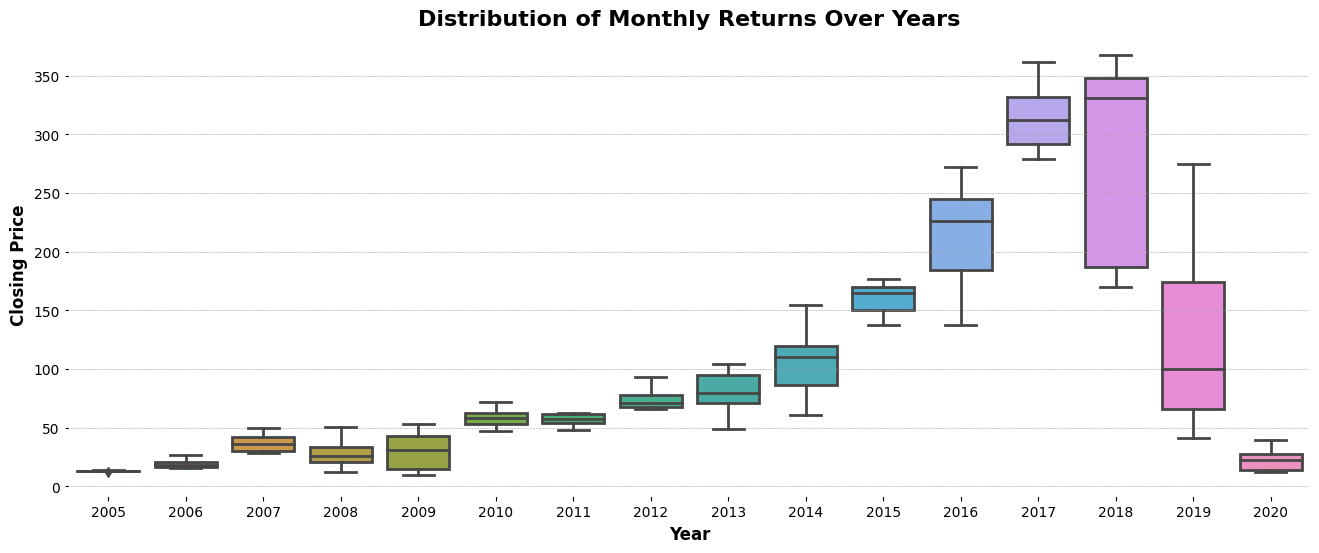

In [23]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='year', y='Close', data=df)
plt.title('Distribution of Monthly Returns Over Years', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.show()

Box plot is an effective way of visualizing the distribution of a quantity. In this case can see how the closing prices are spread out in each year. The closing prices are varied and quite widely spread in the years 2018 and 2019. Widely spread out distributions of closing prices indicate a highly volatile market.

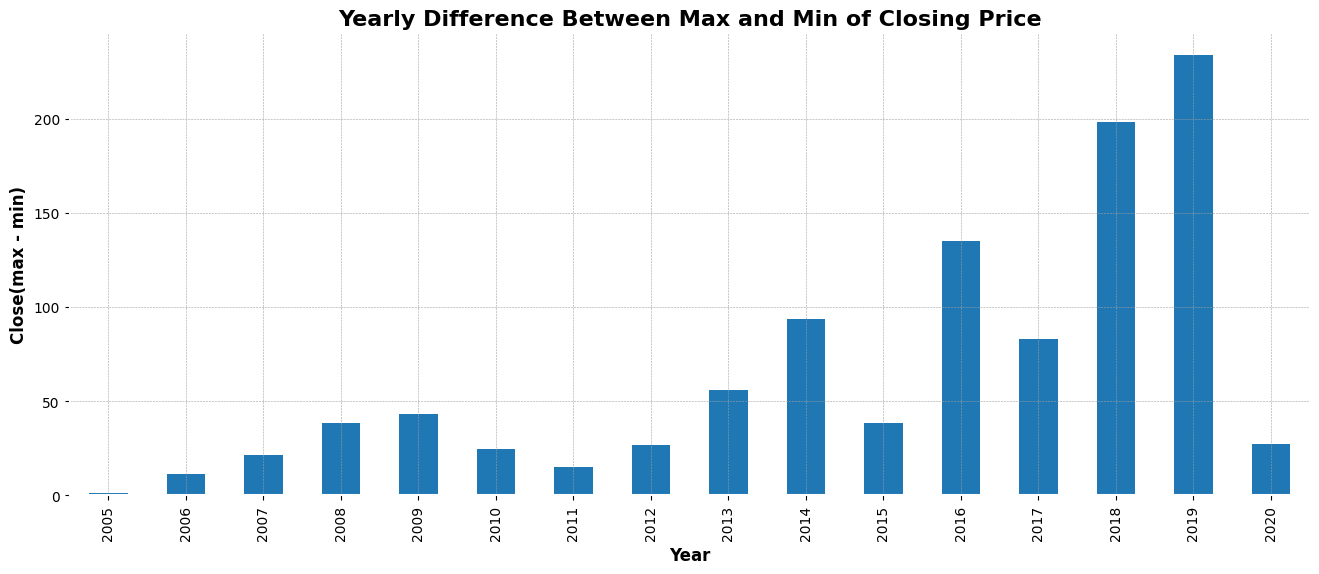

In [24]:
plt.figure(figsize=(16, 6))
df.groupby('year')['Close'].apply(lambda x:max(x)-min(x)).plot(kind='bar')
plt.title('Yearly Difference Between Max and Min of Closing Price', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.xlabel('Year')
plt.ylabel('Close(max - min)')

plt.show()

This chart shows the most change in the closing prices each year. The years 2018 and 2019 show the most change in the closing prices. This chart can be another gauge to determine which years showed the most movement in terms of stocks bought or sold.

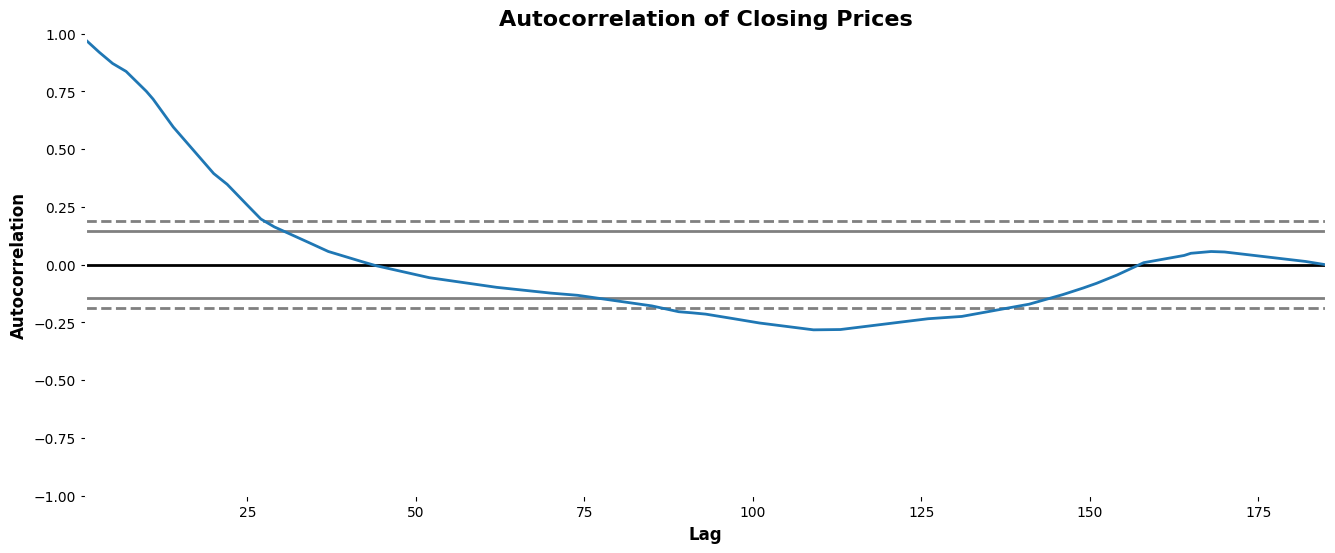

In [25]:
plt.figure(figsize=(16, 6))
pd.plotting.autocorrelation_plot(df['Close'])
plt.title('Autocorrelation of Closing Prices', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.show()

An autocorrelation plot helps in showing the correlation of the closing prices with its lagged values. The correlation values are fairly high within a lag of around 10. So this means the closing prices have some correlation with the prices 10 months or less prior. It is not surprising that the stock prices within half a year are correlated with each other.

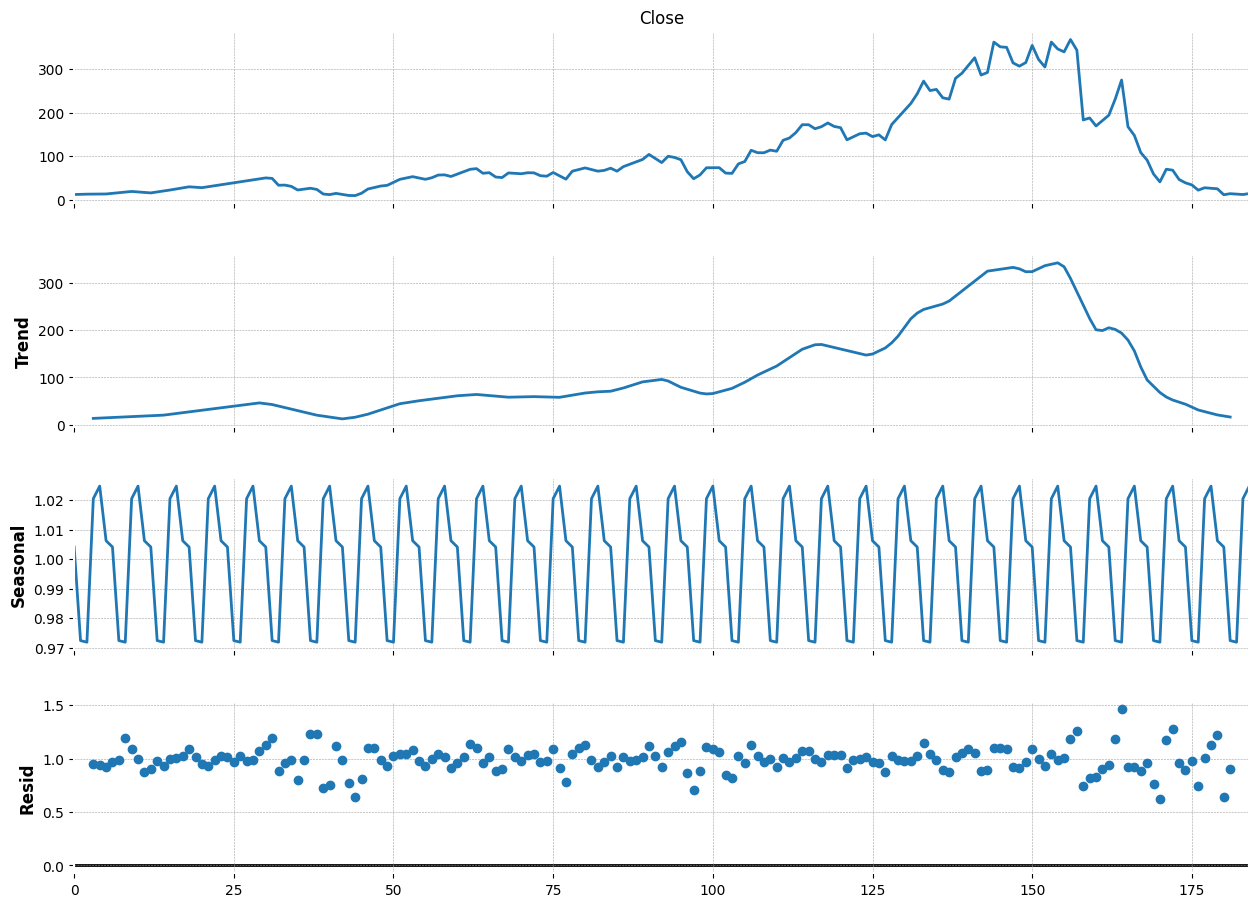

In [26]:
# seasonal decomposition plot

_ = seasonal_decompose(df['Close'], model='multiplicative', period=6)
fig = _.plot()
fig.set_size_inches(14, 10)
plt.show()

A seasonal decomposition plot helps us in separately analyzing the trend, seasonality and residuals. There is no consistent trend in the prices as one can see a gradual increment, a brief peak and then a quick decrement. There seems to be some seasonality but the value osciallates around 2-3% of the price. Finally, there seems to be some considerable noise, especially towards the end as seen in the residual plot. The noise in the residual plot might suggest some unexpected changes in the market which couldn't be captured by the trend or the seasonality component.

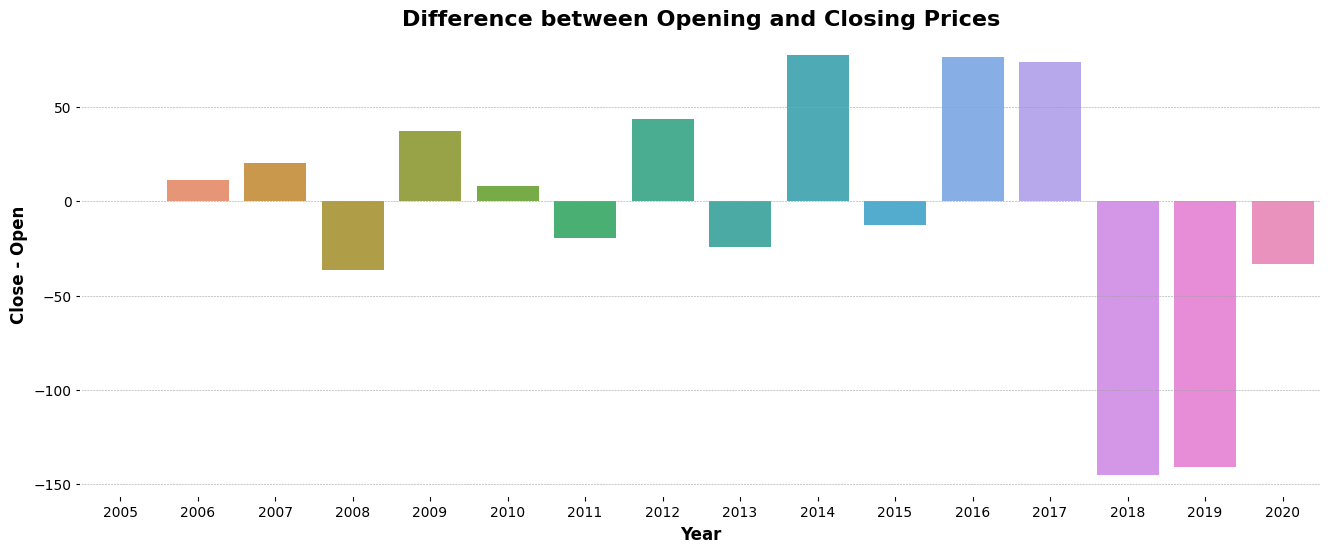

In [39]:
_ = pd.concat([df['year'], pd.Series(df['Close']-df['Open'],name='diff')], axis=1)
_ = _.groupby('year').sum()

plt.figure(figsize=(16, 6))
sns.barplot(x=_.index,y='diff', data=_)
plt.title('Difference between Opening and Closing Prices', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.xlabel('Year')
plt.ylabel('Close - Open')

plt.show()

A barplot showing the difference between the opening and closing prices over each year gives an indication to both the trend and voltality of the stock price. The positive bars indicate the rising of prices while the deep negative bars indicate a sharp fall in prices during the respective years. Starting at 2014, the prices seem to rise overall until 2018 when it falls drastically. This could be a motivator for further investigation/research as to why such drastic changes took place.

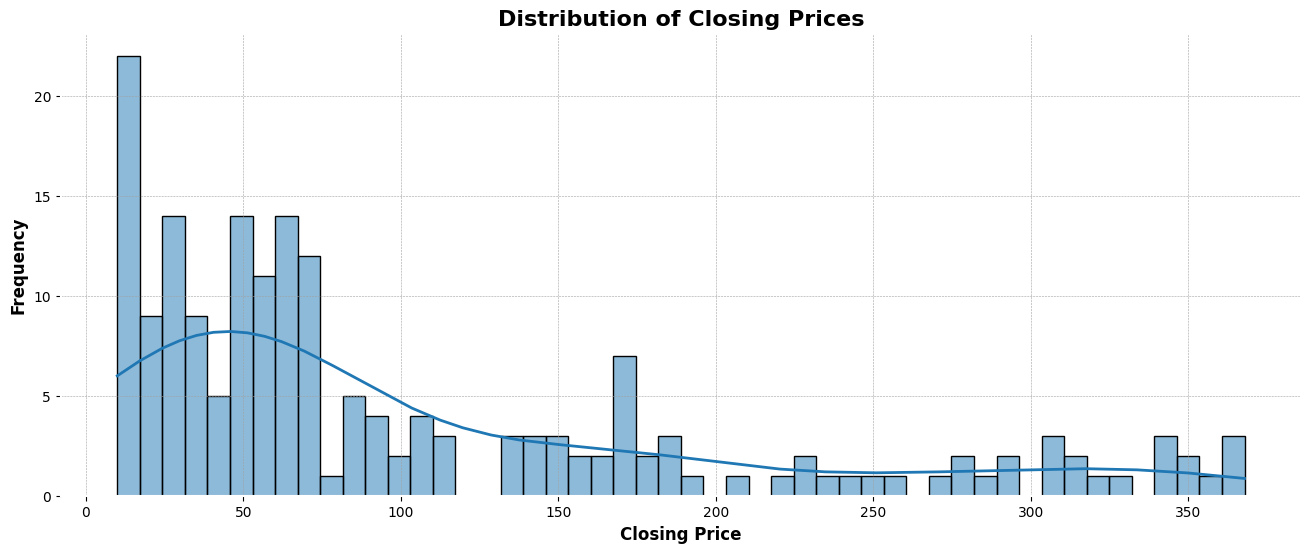

In [40]:
plt.figure(figsize=(16, 6))
sns.histplot(df['Close'], bins=50, kde=True)
plt.title('Distribution of Closing Prices', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.show()

A histogram shows the distribution of closing prices. A major portion of the prices are from the lower range. The distribution shows that for some reason the stock prices haven't consistently been on the higher end. This could either mean that the stock prices have recently risen or the peak(s) of the prices were short lived.

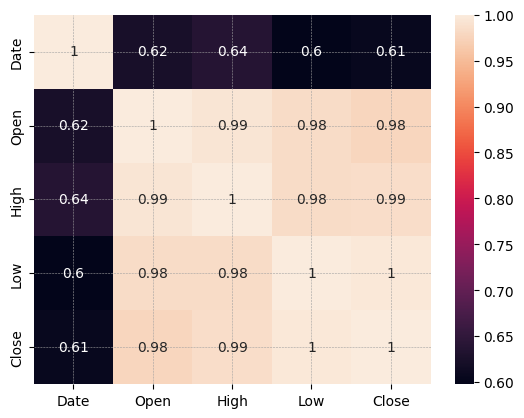

In [41]:
# correlation heatmap

_= df.iloc[:,:5].corr()
sns.heatmap(data=_, annot=True);

A correlation heatmap gives a quick overview of the linear dependance between the features of the dataset. There is a high correlation among the opening, closing, low and high prices. The four features are also moderately correlated with Date. The first part is to be expected and the second part is also not surprising if the change in prices over time is somewhat linear for periods of time.

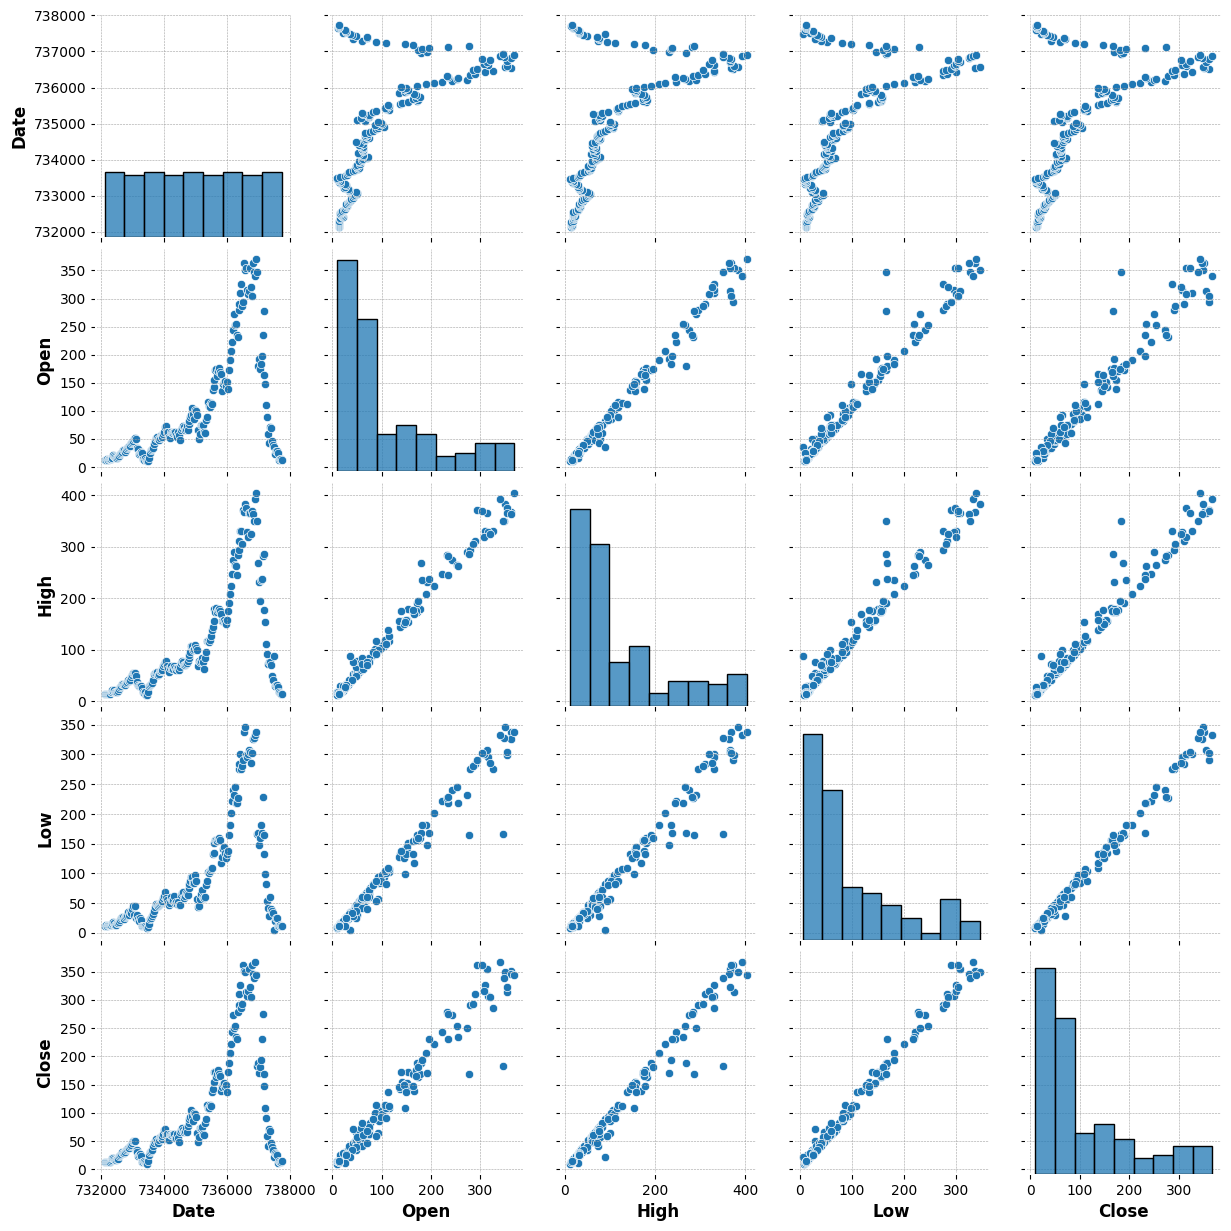

In [42]:
# pairplot

_ = df.iloc[:,:5]
# converting the date column to ordinal numbers to include in the pair plot
_['Date'] = df['Date'].map(pd.Timestamp.toordinal)
sns.pairplot(_);

A pariplot gives a quick visual overview of the correlation between the features and also the distribution of the features themselves. The inference from the scatterplots coincide with our findings from the correlation heatmap. The distribution plots of the prices are all quite similar unsurprisingly. The histogram plot of the closing prices  were plotted previously and it's no different from the plots in the pairplot.

### Hypothesis Testing
- The time-series is either stationary or non-stationary.
- The returns are either normally distributed or they are not.
- There might be some autocorrelation in the stock returns.

#### Hypothetical Statement 1

**H0**: The time series is non-stationary.

**H1**: The time series is stationary.

The ADF test is used to check for the presence of a unit root in a time series, which helps determine if the series is non-stationary. Stationarity implies that the properties of the series, such as mean and variance, do not change over time.

In [43]:
adf_statistic, p_value, used_lag, n_obs, critical_values, icbest = adfuller(df['Close'])
print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print(f'Used Lag: {used_lag}')
print(f'Number of Observations: {n_obs}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')

# Interpretation
if p_value < 0.05:
    print("Reject the null hypothesis - the time series is stationary.")
else:
    print("Fail to reject the null hypothesis - the time series is non-stationary.")

ADF Statistic: -1.9064091411726563
p-value: 0.32905208150043974
Used Lag: 14
Number of Observations: 170
Critical Values:
   1%: -3.469413468959902
   5%: -2.8786964197028295
   10%: -2.5759166089965397
Fail to reject the null hypothesis - the time series is non-stationary.


#### Hypothetical Statement 2

**H0**: The closing price is normally distributed.

**H1**: The closing price is not normally distributed.

The Shapiro-Wilk test is a popular statistical test to check if a given sample comes from a normally distributed population.

In [44]:
statistic, p_value = shapiro(df['Close'])
print(f'Shapiro-Wilk Statistic: {statistic}')
print(f'p-value: {p_value}')

# Interpretation
if p_value < 0.05:
    print("Reject the null hypothesis - the data is not normally distributed.")
else:
    print("Fail to reject the null hypothesis - the data is normally distributed.")

Shapiro-Wilk Statistic: 0.8169776797294617
p-value: 5.694285375255209e-14
Reject the null hypothesis - the data is not normally distributed.


#### Hypothetical Statement 3

**H0**:  The variances of closing prices in different periods are equal.

**H1**:  The variances of closing prices in different periods are not equal.

Levene's test is used to assess the equality of variances for a variable calculated for two or more groups. In this scenario we are comparing the variances during 2008, 2013 and 2018.

In [45]:
y08 = df[df['year']==2008]['Close']
y13 = df[df['year']==2013]['Close']
y18 = df[df['year']==2018]['Close']

levene_stat, levene_p_value = levene(y08, y13, y18)
print(f"Levene's Test Statistic: {levene_stat}")
print(f"p-value: {levene_p_value}")

# Interpretation
if p_value < 0.05:
    print("Reject the null hypothesis - the variances are not equal.")
else:
    print("Fail to reject the null hypothesis - the variances are equal.")

Levene's Test Statistic: 7.408163553274296
p-value: 0.0022002522830144463
Reject the null hypothesis - the variances are not equal.


### Feature Engineering & Data Pre-processing

In [46]:
# Handling Missing Values & Missing Value Imputation

df.reset_index(drop=True, inplace=True)
_ = df['Date'].dt.month

# checking if data for all months in the timeseries is present
for i in range(1,len(_)):

    diff = _[i] - _[i-1]
    if ~diff == 1 or ~diff == 11:
        print(i-1,diff)

In previous observations, it was obvious that there were no apparent missing values. But, as this is a time series dataset, it is important to ensure that there are not missing months in between. The above piece of code makes sure that the months follow one after another serially. If any missing months had been detected, the respective indices would have been printed.

In [47]:
df['month'] = df['Date'].dt.month

The 'month' column has been encoded from month names to ordinal numbers.

In [49]:
# addition of lagged features and quarter column

df['prev_close'] = df['Close'].shift(1)
df['prev_high'] = df['High'].shift(1)
df['prev_low'] = df['Low'].shift(1)
df['prev_open'] = df['Open'].shift(1)
df['quarter'] = df['Date'].dt.quarter

# dropping columns used for the bollinger plot

df = df.drop(['UpperBand','LowerBand'],axis=1)

In [50]:
# data splitting

df.dropna(inplace=True)

X = df.drop(['Close','Date'], axis=1)
y = df['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


# data scaling
scaler = MinMaxScaler()
scaler.fit_transform(X_train)
scaler.transform(X_test);

I have taken 20% of the data as the test set as there isn't an abundance of data available. While splitting, the dataset has not be shuffled as we want to keep the order of data as we are dealing with a time series dataset.

### ML Model Implementation

Evaluation metrics:
- RMSE is intuitive and easy to interpret in the same units as the target variable (Rs. for stock prices)
- MAE is robust to outliers compared to RMSE and provides a straightforward measure of average prediction error.
- MAPE provides a percentage-based measure, which can be more intuitive for stakeholders to interpret, especially in financial or forecasting contexts.

In [ ]:
# function to create an evaluation metric chart

def eval_charts(y_pred):

    fig, ax = plt.subplots(2,2, figsize=(10,10))

    sns.scatterplot(y=y_pred,x=y_test,ax=ax[0,0])
    sns.lineplot(y=y_test,x=y_test,ax=ax[0,0],color='red',alpha=0.6)
    ax[0,0].set_title('Predictions vs True Values', fontdict={'fontsize':14, 'fontweight':'bold'})
    ax[0,0].set(ylabel='y_pred', xlabel='y_test')

    sns.scatterplot(y=y_test-y_pred,x=y_test,ax=ax[0,1])
    sns.lineplot(y=[0]*5,x=np.linspace(0,380,5),ax=ax[0,1],color='red',alpha=0.6)
    ax[0,1].set_title('Residual Plot', fontdict={'fontsize':14, 'fontweight':'bold'})
    ax[0,1].set(xlabel='y_pred', ylabel='y_test - y_pred')

    sns.histplot(x=y_test-y_pred,ax=ax[1,0])
    ax[1,0].set_title('Residual Distribution', fontdict={'fontsize':14, 'fontweight':'bold'})
    ax[1,0].set(xlabel='Residual', ylabel='Count')

    ax[1,1].plot(np.linspace(0,len(y_test),len(y_test)),y_test, label='Actual')
    ax[1,1].plot(np.linspace(0,len(y_test),len(y_test)),y_pred, label='Predicted')
    ax[1,1].set(xlabel='Time', ylabel='Close')
    ax[1,1].set_title('Time Series Plot', fontdict={'fontsize':14, 'fontweight':'bold'})
    ax[1,1].legend()

    fig.suptitle('Evaluation Charts', fontsize=17)

    plt.tight_layout(h_pad=5, w_pad=5,pad=3)
    plt.show()

#### KNN Regressor

In [70]:
# ML Model - 1 Implementation
knn = KNeighborsRegressor()
# Fitting the Algorithm
knn.fit(X_train,y_train)
# Predicting on the model
y_pred = knn.predict(X_test)

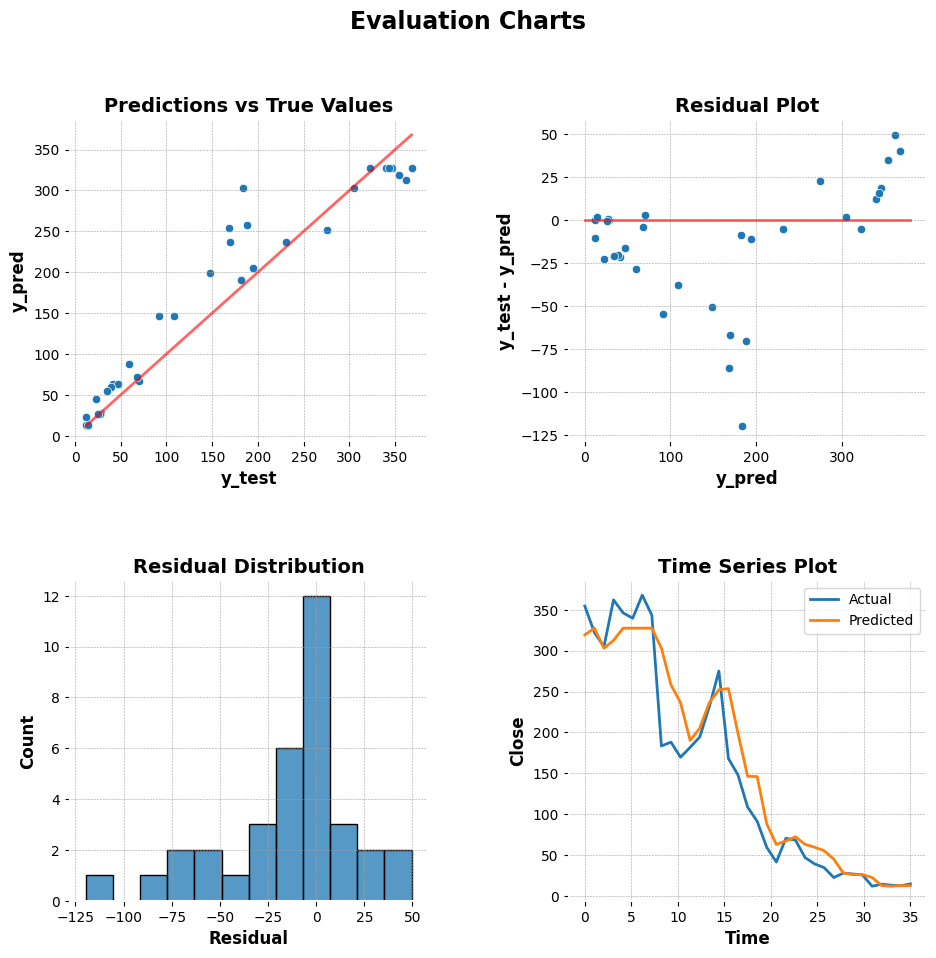

In [71]:
# Visualizing evaluation Metric Score chart
eval_charts(y_pred)

In [75]:
print('\nEVALUATION SCORES:\n')
print(f'MAE: {mean_absolute_error(y_test,y_pred).round(2)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test,y_pred).round(2)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test,y_pred)).round(2)}')


EVALUATION SCORES:

MAE: 24.72
MAPE: 0.25
RMSE: 36.97


In [72]:
# hyperparameter tuning

param_grid = {'n_neighbors':[3,5,7,9,11],
              'p':[1,2]}
grid = GridSearchCV(knn,param_grid)

grid.fit(X_train,y_train)

y_pred = grid.predict(X_test)
grid.best_params_

{'n_neighbors': 5, 'p': 2}

The grid search leads to the default parameters of KNeighborsRegressor.

In [74]:
print('\nEVALUATION SCORES:\n')
print(f'MAE: {mean_absolute_error(y_test,y_pred).round(2)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test,y_pred).round(2)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test,y_pred)).round(2)}')


EVALUATION SCORES:

MAE: 24.72
MAPE: 0.25
RMSE: 36.97


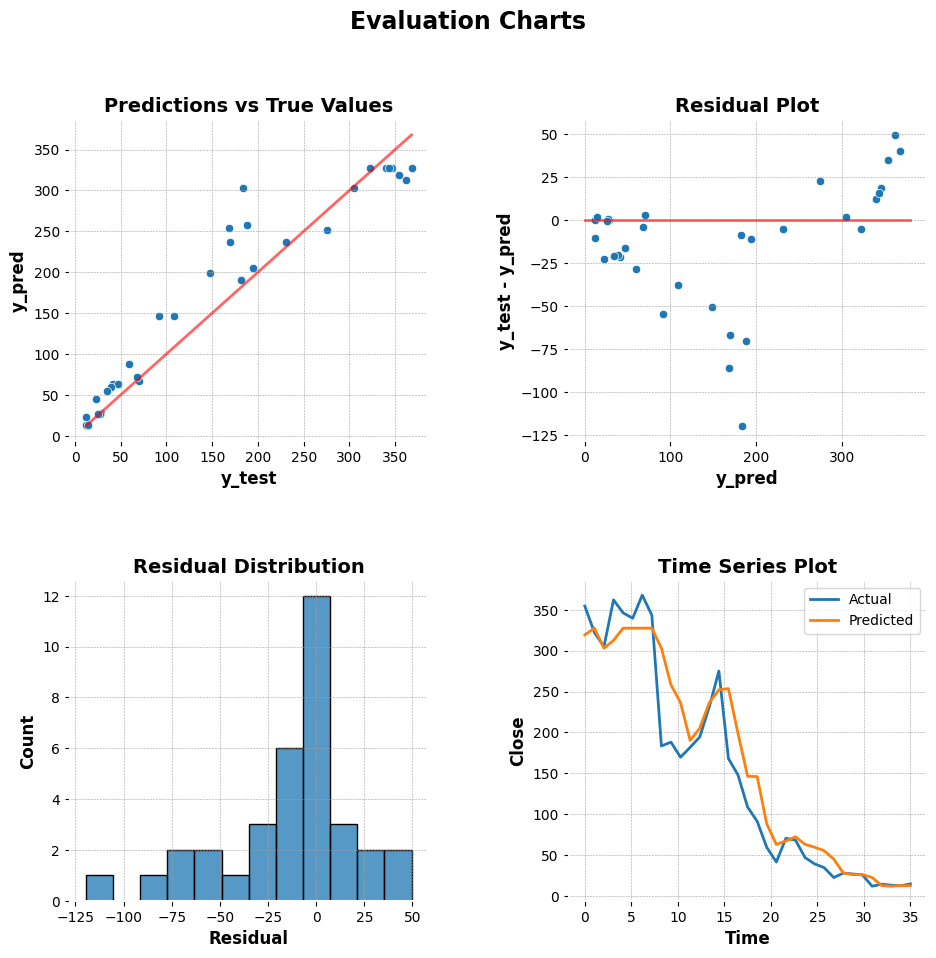

In [73]:
eval_charts(y_pred)

#### Random Forest Regressor

In [51]:
# ML Model - 2 Implementation
rf_model = RandomForestRegressor()
# Fitting the Algorithm
rf_model.fit(X_train,y_train)
# Predicting on the model
y_pred = rf_model.predict(X_test)

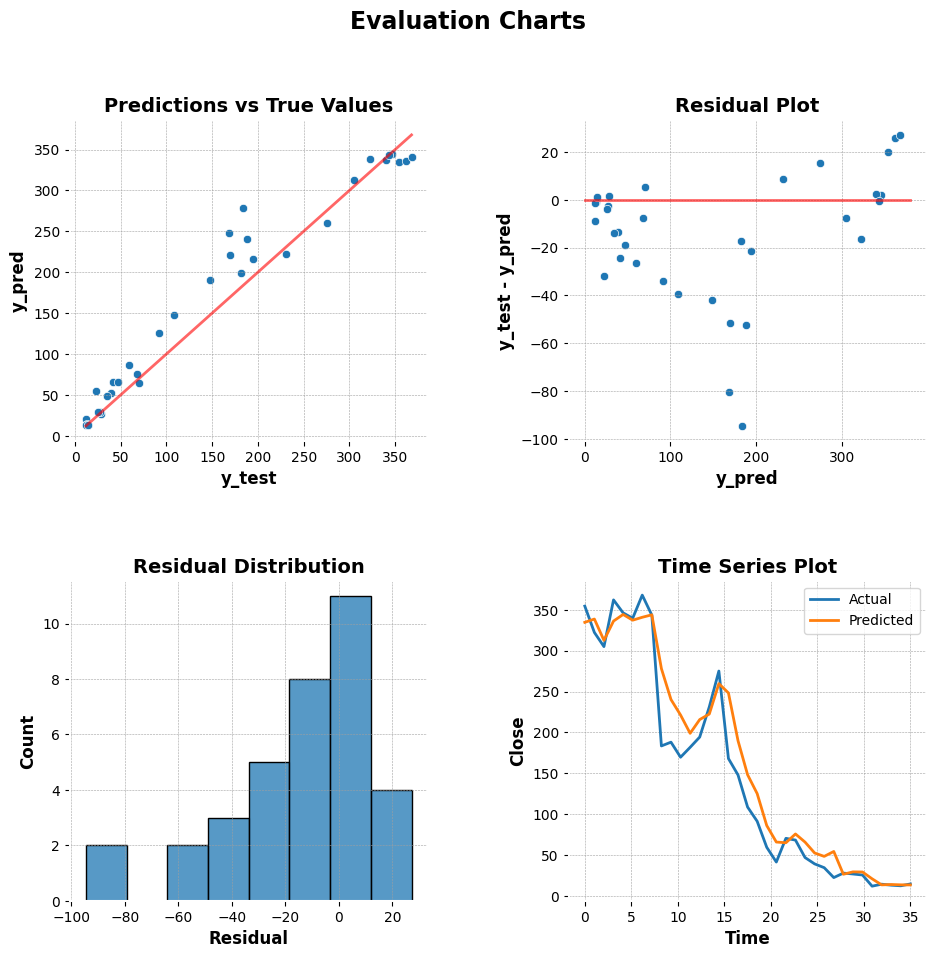

In [53]:
eval_charts(y_pred)

In [54]:
print('\nEVALUATION SCORES:\n')
print(f'MAE: {mean_absolute_error(y_test,y_pred).round(2)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test,y_pred).round(2)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test,y_pred)).round(2)}')


EVALUATION SCORES:

MAE: 20.6
MAPE: 0.24
RMSE: 30.08


In [55]:
# hyperparameter tuning

param_grid = {'n_estimators':[100,150,200],
              'max_features':[1.0,4,6,8],
              'bootstrap':[True,False]}
grid = GridSearchCV(rf_model,param_grid)

grid.fit(X_train,y_train)
print(grid.best_params_)
y_pred = grid.predict(X_test)

{'bootstrap': True, 'max_features': 1.0, 'n_estimators': 150}


In [56]:
print('\nEVALUATION SCORES:\n')
print(f'MAE: {mean_absolute_error(y_test,y_pred).round(2)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test,y_pred).round(2)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test,y_pred)).round(2)}')


EVALUATION SCORES:

MAE: 19.87
MAPE: 0.22
RMSE: 30.11


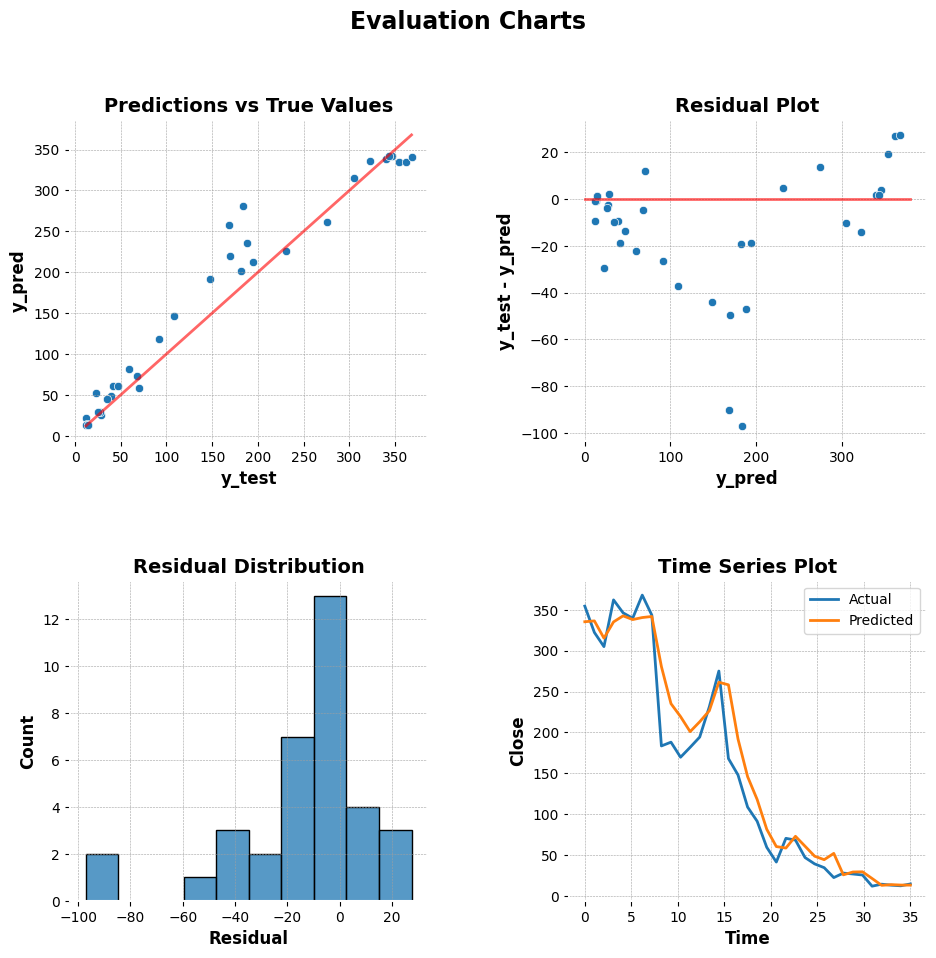

In [57]:
eval_charts(y_pred)

<Axes: xlabel='estimators'>

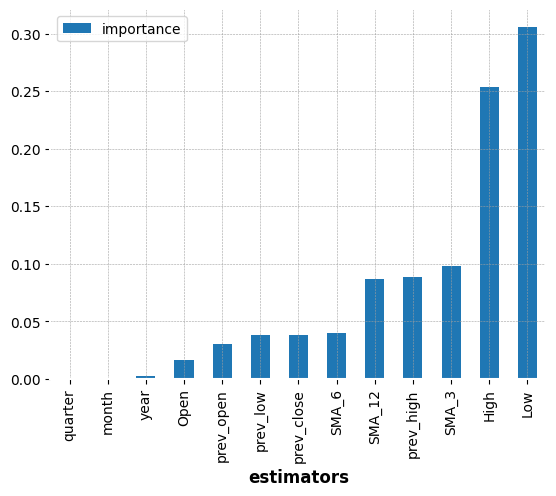

In [61]:
# feature importances

pd.DataFrame({'estimators': X_test.columns,
             'importance': grid.estimator.feature_importances_}).sort_values(by='importance').plot.bar(x='estimators',y='importance')

#### XGBoost Regressor

In [62]:
# ML Model - 3 Implementation
xgb_model = xgb.XGBRegressor()

# Fitting the Algorithm
xgb_model.fit(X_train,y_train)

# Predicting on the model
y_pred = xgb_model.predict(X_test)

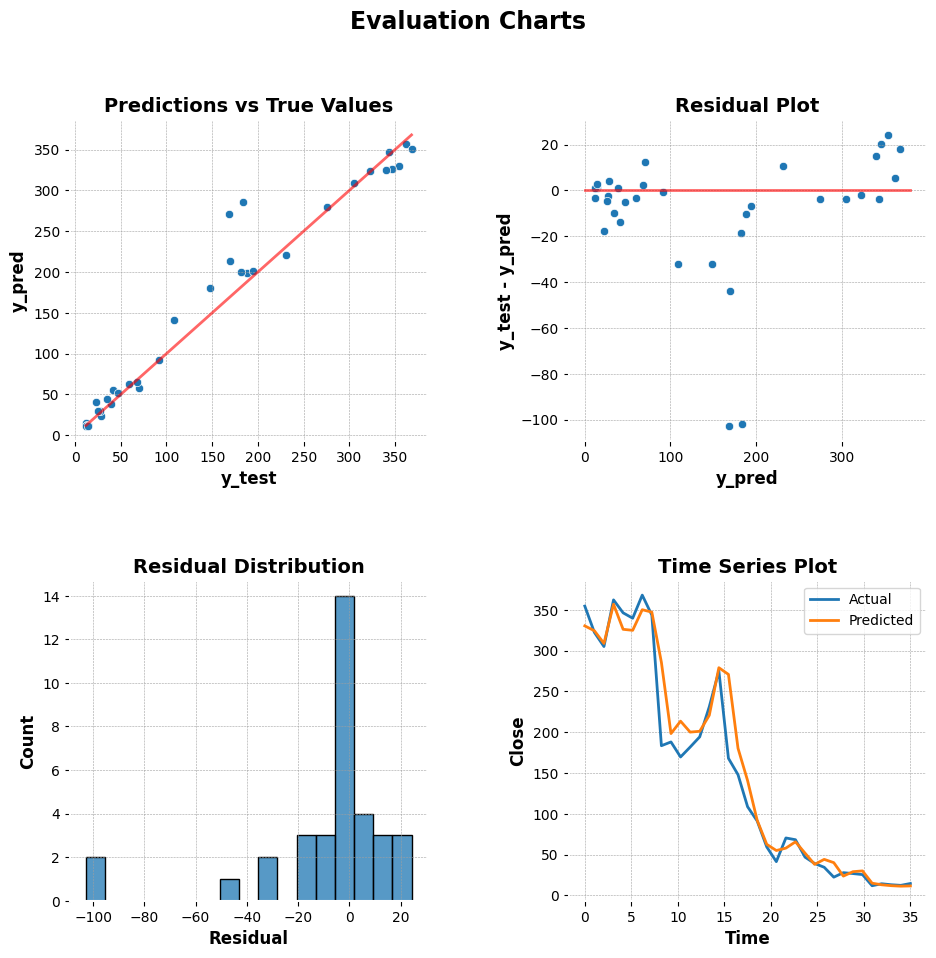

In [63]:
# Visualizing evaluation Metric Score chart

eval_charts(y_pred)

In [64]:
print('\nEVALUATION SCORES:\n')
print(f'MAE: {mean_absolute_error(y_test,y_pred).round(2)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test,y_pred).round(2)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test,y_pred)).round(2)}')


EVALUATION SCORES:

MAE: 15.46
MAPE: 0.15
RMSE: 28.3


In [65]:
# hyperparameter tuning

param_grid = {'eta':[0.05,0.1,0.3],
              'gamma':[0,20,150],
              'max_features':[1.0,4,6,8],
              'lambda':[0.5,1,10,30],
              'alpha':[0.5,1,5,10]}
grid = GridSearchCV(xgb_model,param_grid)
# Fit the Algorithm
grid.fit(X_train,y_train)
print(grid.best_params_)
# Predict on the model
y_pred = grid.predict(X_test)

{'alpha': 0.5, 'eta': 0.1, 'gamma': 20, 'lambda': 10, 'max_features': 1.0}


In [66]:
print('\nEVALUATION SCORES:\n')
print(f'MAE: {mean_absolute_error(y_test,y_pred).round(2)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test,y_pred).round(2)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test,y_pred)).round(2)}')


EVALUATION SCORES:

MAE: 18.14
MAPE: 0.19
RMSE: 29.45


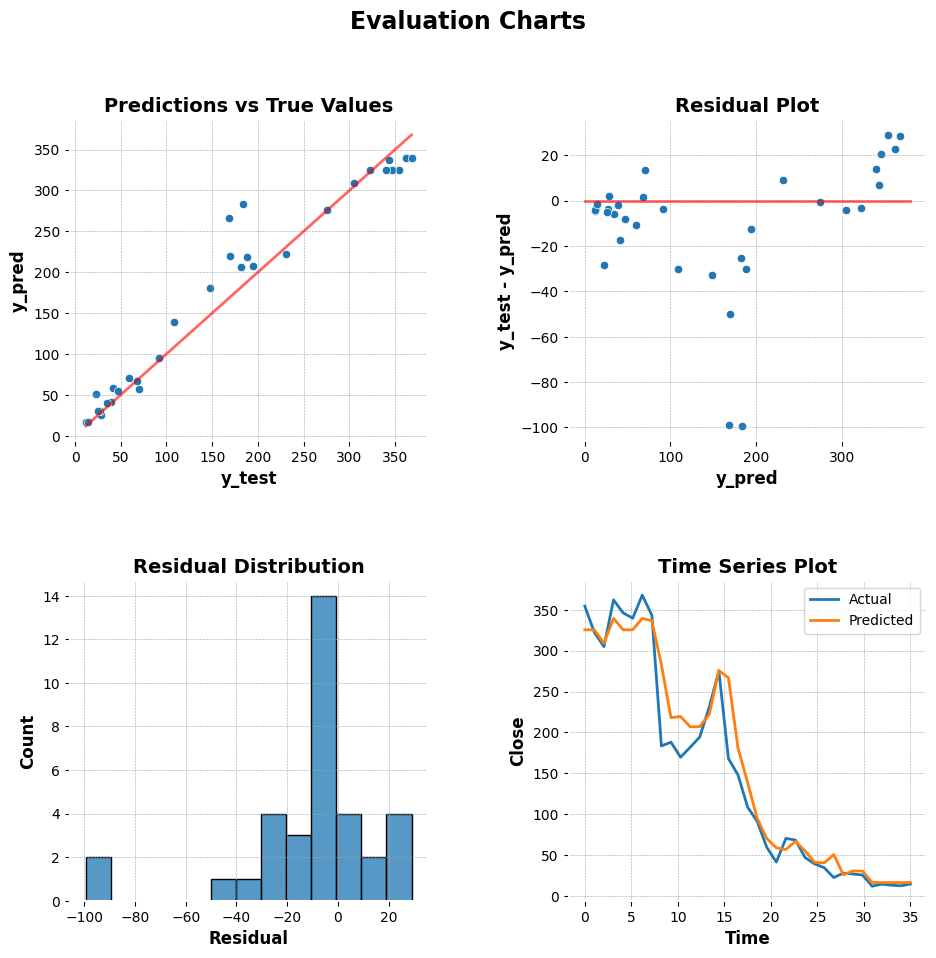

In [67]:
eval_charts(y_pred)

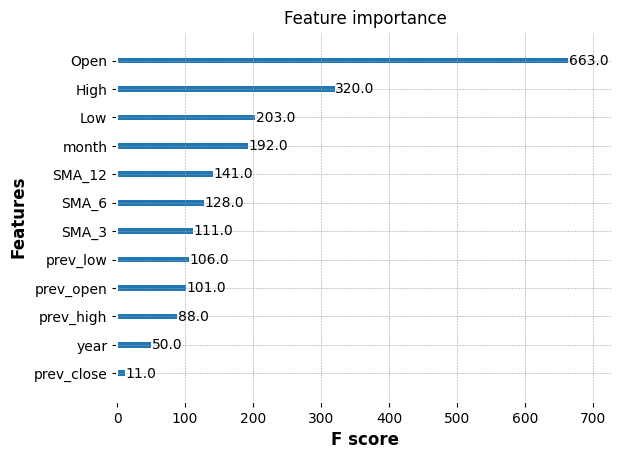

In [68]:
xgb.plot_importance(xgb_model,importance_type='weight');

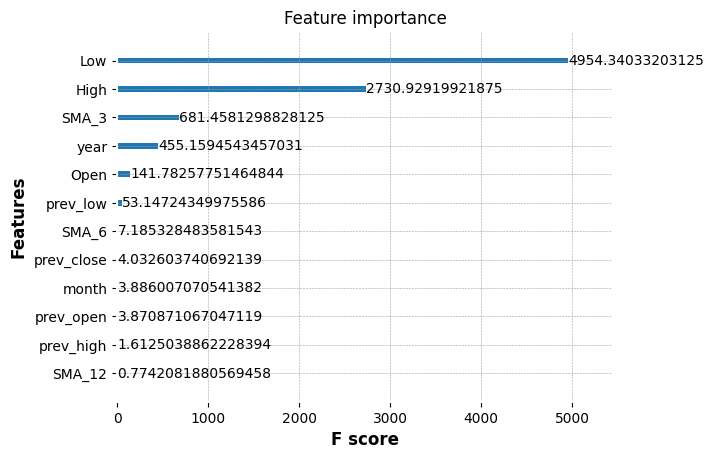

In [69]:
xgb.plot_importance(xgb_model,importance_type='gain');

### Conclusion

After exploring the three models RandomForest Regressor, XGBoost Regressor and KNeighbors Regressor, it is evident from the evaluation metric scores that the XGBoost Regressor performs the best. But it is important to note that the dataset contains monthly data. So the fact that all three models manage to resonably predict the general trend of the closing prices for over 30 points is quite impressive.